In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

import random
from IPython.display import clear_output

In [68]:
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

text[:50]

'First Citizen:\nBefore we proceed any further, hear'

In [54]:
chars = sorted(set(text))

print('Vocab is ', chars)

print('Vocab size is ', len(chars))

Vocab is  ['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Vocab size is  65


In [8]:
def get_batch_data(data, context_len, batch_size):
    # random starting points of batches
    starting_indices = [random.randint(0, len(data) - context_len) for _ in range(batch_size)]
    # get the context and target for each batch
    context = [data[i:i+context_len] for i in starting_indices]
    target = [data[i+1:i+context_len+1] for i in starting_indices]
    return context, target


In [19]:
CONTEXT_LEN = 4
BATCH_SIZE = 8
VOCAB_SIZE = len(chars)
get_batch_data(text, 4, 8)

(['her ', ';\nAn', 'rnin', ' any', 'ave ', ' Luc', 'or u', 'ng t'],
 ['er f', '\nAnd', 'ning', 'any ', 've r', 'Luce', 'r us', 'g to'])

In [11]:
# make a dict from chars to idx(0,1,2,3)
char_to_idx = {char: idx for idx, char in enumerate(chars)}
idx_to_char = {idx: char for idx, char in enumerate(chars)}

In [16]:
input, output = get_batch_data(text, 4, 8)
# convert input into a 8 x 4 tensor
input_tensor_B_C = torch.tensor([[char_to_idx[char] for char in seq] for seq in input])
output_tensor = torch.tensor([[char_to_idx[char] for char in seq] for seq in output])
input_tensor_B_C.shape, output_tensor.shape

(torch.Size([8, 4]), torch.Size([8, 4]))

In [43]:
# Zero Layer Transformer
class ZeroLayerTransformer(nn.Module):
    def __init__(self, vocab_size, emb_dim):
        super().__init__()
        # random tensor of Vocab size x emb dim
        self.emb_V_E = nn.Parameter(torch.randn(vocab_size, emb_dim))
        self.unemb_E_V = nn.Parameter(torch.randn(emb_dim, vocab_size))

    def forward(self, x_B_C_V):
        x_B_C_E = x_B_C_V @ self.emb_V_E
        x_B_C_V = x_B_C_E @ self.unemb_E_V
        return x_B_C_V

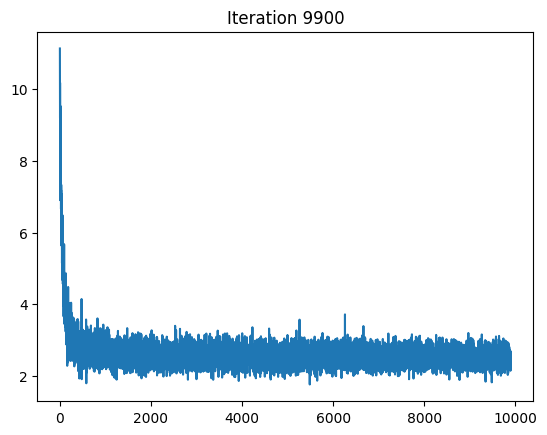

In [46]:
EMB_DIM = 16
model = ZeroLayerTransformer(VOCAB_SIZE, EMB_DIM)
optimizer = optim.Adam(model.parameters(), lr=0.01)
entropy_loss = nn.CrossEntropyLoss()
loss_arr = []

for iter in range(10000):
    optimizer.zero_grad()
    
    input, output = get_batch_data(text, CONTEXT_LEN, BATCH_SIZE)
    input_tensor_B_C = torch.tensor([[char_to_idx[char] for char in seq] for seq in input])
    output_tensor_B_C = torch.tensor([[char_to_idx[char] for char in seq] for seq in output])

    input_tensor_B_C_V = F.one_hot(input_tensor_B_C, num_classes=VOCAB_SIZE).float()
    output_tensor_B_C_V = F.one_hot(output_tensor_B_C, num_classes=VOCAB_SIZE).float()


    model_output_B_C_V = model(input_tensor_B_C_V)
    model_output_B_V_C = torch.permute(model_output_B_C_V, (0, 2, 1))
    output_tensor_B_V_C = torch.permute(output_tensor_B_C_V, (0, 2, 1))

    loss = entropy_loss(model_output_B_V_C, output_tensor_B_V_C)
    loss.backward()
    optimizer.step()

    loss_arr.append(loss.item())
    if iter % 100 == 0:
        clear_output(wait = True)
        plt.plot(loss_arr); plt.title(f'Iteration {iter}'); plt.show()



In [48]:
loss_arr[-1]

2.710357189178467

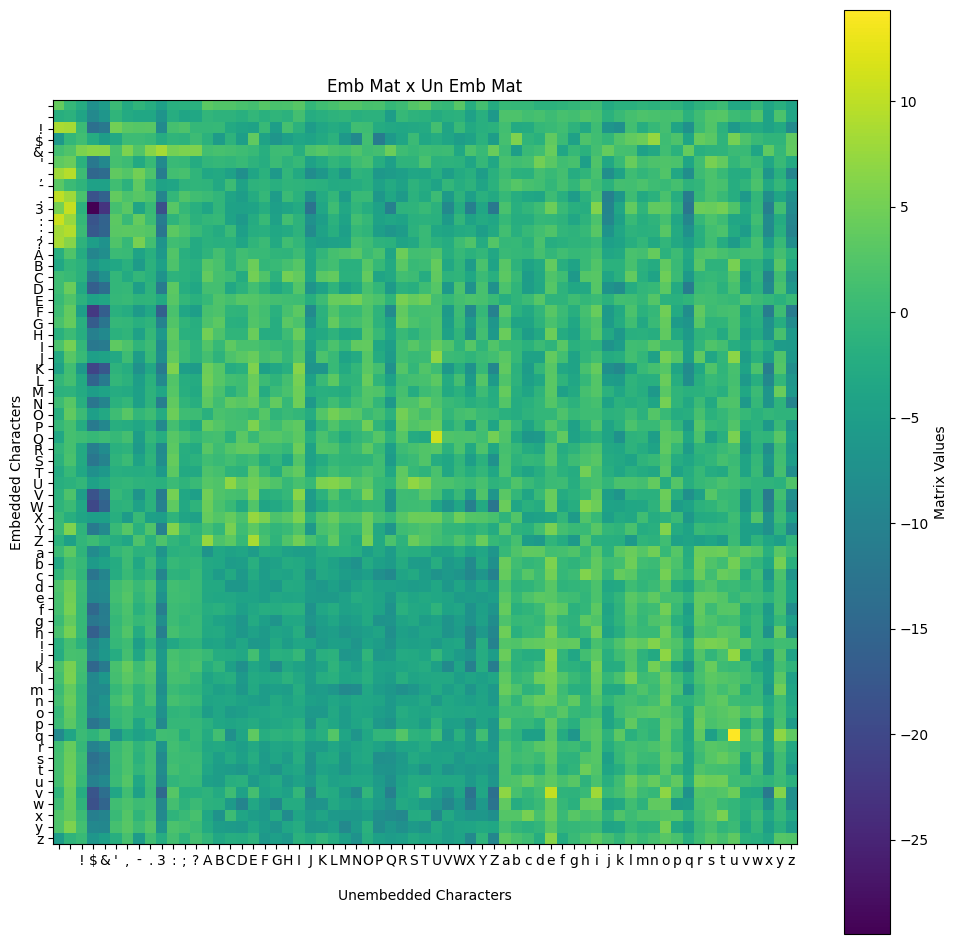

In [92]:
# Emb Mat x Un Emb Mat
with torch.no_grad():
    Emb_times_Unemb = model.emb_V_E @ model.unemb_E_V

# visualize the matrix Emb_times_Unemb
plt.figure(figsize=(12, 12))  # Increase the figure size for better readability
plt.imshow(Emb_times_Unemb)
plt.title('Emb Mat x Un Emb Mat')
plt.colorbar(label='Matrix Values')
chars = [idx_to_char[i] for i in range(VOCAB_SIZE)]
plt.xticks(ticks=range(VOCAB_SIZE), labels=chars)
plt.yticks(ticks=range(VOCAB_SIZE), labels=chars)
plt.xlabel('Unembedded Characters')
plt.ylabel('Embedded Characters')
plt.show()


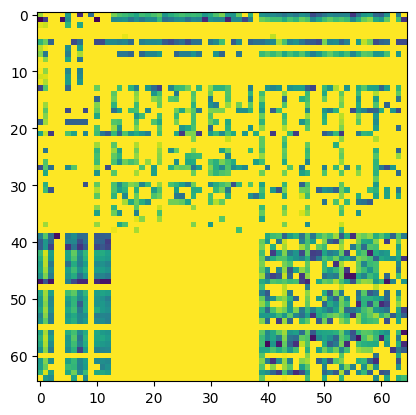

In [93]:
import numpy as np
import collections
import math

def create_bigram_matrix(text):

    # Step 1: Identify all unique characters
    characters = sorted(set(text))
    char_to_index = {char: idx for idx, char in enumerate(characters)}

    # Step 2: Count characters and bigrams
    char_counts = collections.Counter(text)
    bigram_counts = collections.Counter(zip(text, text[1:]))

    # Step 3: Create the matrix
    size = len(characters)
    likelihood_matrix = np.zeros((size, size))

    # Step 4: Populate the matrix with log likelihoods
    for (c1, c2), count in bigram_counts.items():
        if c1 in char_to_index and c2 in char_to_index:
            idx1 = char_to_index[c1]
            idx2 = char_to_index[c2]
            bigram_prob = count / char_counts[c1]
            likelihood_matrix[idx1, idx2] = math.log(bigram_prob)
    
    return characters, likelihood_matrix

# Example usage
_, likelihood_matrix = create_bigram_matrix(text)

# visualize log_likelihood matrix
plt.imshow(likelihood_matrix)
plt.show()


In [94]:
# apply softmax to each row for both Emb_times_Unemb and likelihood matrix
likelihood_matrix = F.softmax(torch.tensor(likelihood_matrix), dim=1)
Emb_times_Unemb = F.softmax(Emb_times_Unemb, dim=1)

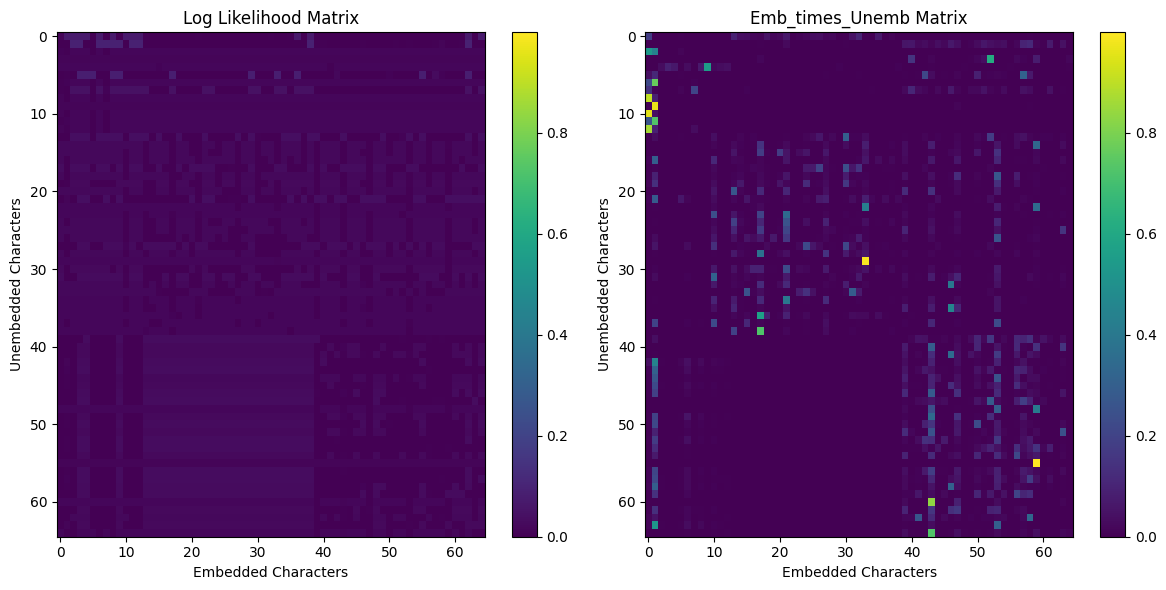

In [96]:
# convert Emb_times_Unemb into a numpy matrix
Emb_times_Unemb_np = Emb_times_Unemb.detach().numpy()
likelihood_matrix_np = likelihood_matrix.detach().numpy()

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Visualize likelihood matrix
vmin = min([np.min(likelihood_matrix_np), np.min(Emb_times_Unemb_np)])
vmax = max([np.max(likelihood_matrix_np), np.max(Emb_times_Unemb_np)])

im0 = axs[0].imshow(likelihood_matrix_np, aspect='auto', vmin=vmin, vmax=vmax)
axs[0].set_title('Log Likelihood Matrix')
axs[0].set_xlabel('Embedded Characters')
axs[0].set_ylabel('Unembedded Characters')
fig.colorbar(im0, ax=axs[0], orientation='vertical')

# Assuming Emb_times_Unemb is another matrix to be visualized
im1 = axs[1].imshow(Emb_times_Unemb_np, aspect='auto', vmin=vmin, vmax=vmax)
axs[1].set_title('Emb_times_Unemb Matrix')
axs[1].set_xlabel('Embedded Characters')
axs[1].set_ylabel('Unembedded Characters')
fig.colorbar(im1, ax=axs[1], orientation='vertical')

plt.tight_layout()
plt.show()